In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats

import utils
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale
from einops import rearrange, reduce, repeat


In [9]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

# Measuring dimensionality for each trial and each health subject

In [7]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[0]

# compute dimensionality 
def add_dim(subj, task):
    df = utils.LoadData.behaviorData(subj, task)
    x, h, y = utils.LoadData.xhy(subj, task)
    
    ### change here
    x = [rearrange(i, 'b t f -> b (t f)') for i in x]
    
    dims = []
    for h_ in x:
        h_ = scale(h_, axis=0)
        dims.append(utils.Analysis.dim_measure(h_))
    df_ = df
    df_['dim'] = dims    
    return df_
    
df_all = utils.GroupOperation.map(add_dim, subjs, task)
df_all_ = pd.concat(df_all, axis=0)


|████████████████████████████████████████| 50/50 [100%] in 14.7s (3.39/s) 


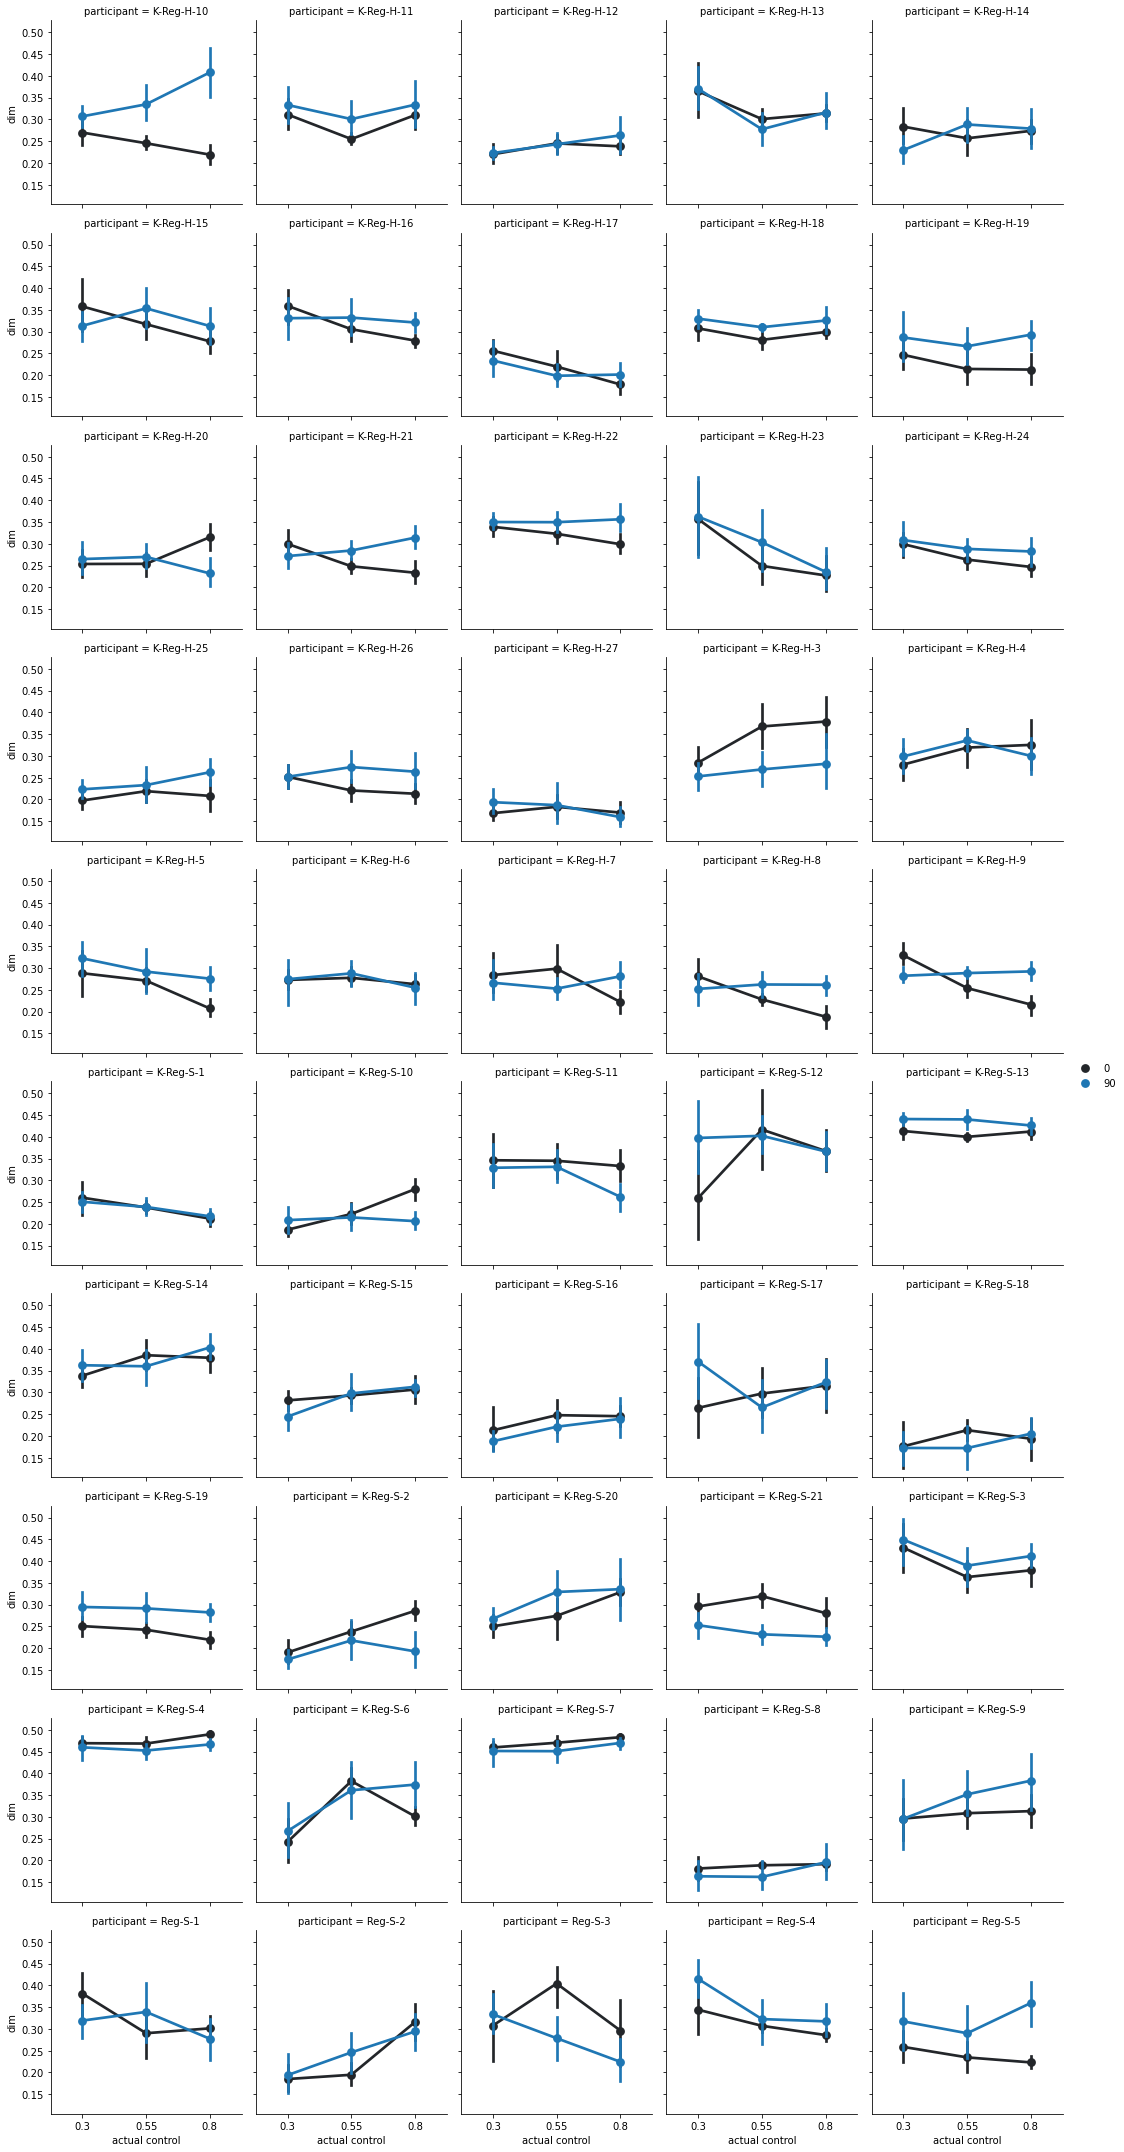

In [3]:
# plot dimensionality by conditions and subjects
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_all_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='dim', 
                   hue='angular bias')
grid.add_legend()



## logistic regression on dimensionality and response

In [10]:
def reg_dim_resp(subj, task):
    df_dim = add_dim(subj, task)
    df_dim = sm.add_constant(df_dim)
    logit_res = sm.Logit(df_dim['response'], df_dim[['dim', 'const']]).fit()
    return logit_res

logit_res = utils.GroupOperation.map(reg_dim_resp, subjs, task)

on 0: Optimization terminated successfully.                                                                             
on 0:          Current function value: 0.422742                                                                         
on 0:          Iterations 8                                                                                             
on 1: Optimization terminated successfully.                                                                             
on 1:          Current function value: 0.609899                                                                         
on 1:          Iterations 6                                                                                             
on 2: Optimization terminated successfully.                                                                             
on 2:          Current function value: 0.450548                                                                         
on 2:          Iterations 6     

In [11]:
# extract coefficients and compute group t-test
dim_beta = [x.params['dim'] for x in logit_res]
scipy.stats.ttest_1samp(dim_beta, 0)

Ttest_1sampResult(statistic=-1.8042071782402047, pvalue=0.07734717771155696)

So we have even stronger results in the execution space

# Three dot

In [12]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[1]

# compute dimensionality 
def add_dim(subj, task):
    df = utils.LoadData.behaviorData(subj, task)
    x, h, y = utils.LoadData.xhy(subj, task)
    
    ### change here
    x = [rearrange(i, 'b t f -> b (t f)') for i in x]
    
    dims = []
    for h_ in x:
        h_ = scale(h_, axis=0)
        dims.append(utils.Analysis.dim_measure(h_))
    df_ = df
    df_['dim'] = dims    
    return df_
    
df_all = utils.GroupOperation.map(add_dim, subjs, task)
df_all_ = pd.concat(df_all, axis=0)

|████████████████████████████████████████| 50/50 [100%] in 18.4s (2.72/s)                                               


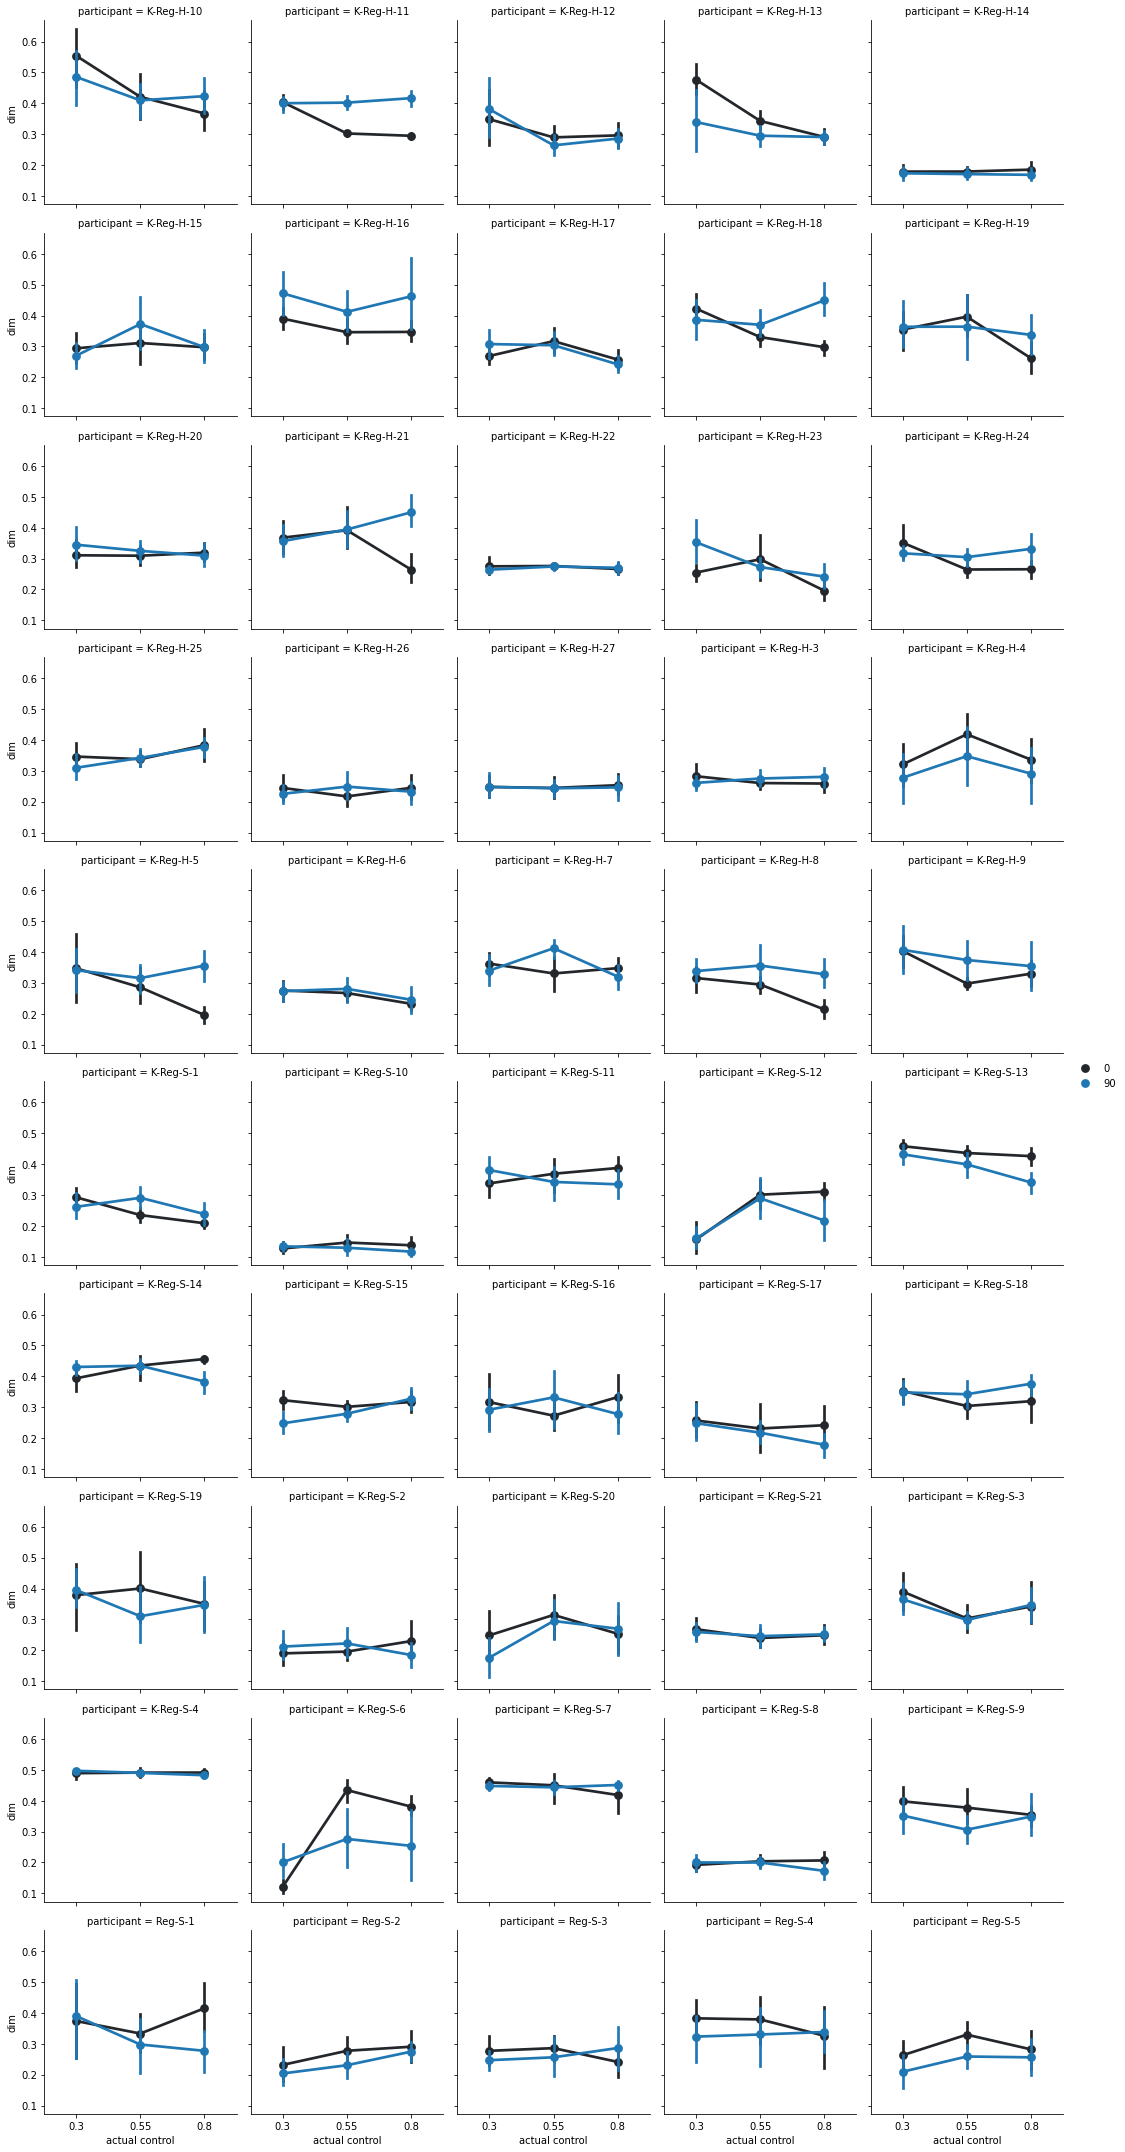

In [13]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_all_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='dim', 
                   hue='angular bias')
grid.add_legend()

In [ ]:
df_all_group = df_all_.copy()
df_all_group = df_all_group.drop(['trial no.', 'response'], axis=1)
df_all_group = df_all_group.groupby(['group', 'participant', 'actual control', 'angular bias'])
df_all_group = df_all_group.mean().reset_index()
sns.catplot(x='actual control', y='dim', hue='angular bias', data=df_all_group, col='group', kind='point')